# Statistical sensitivity

#### Literature
See:  
S. Mertens et al  
Sensitivity of next-generation tritium beta-decay experiments for keV-scale sterile neutrinos  
JCAP02(2015)020  
https://iopscience.iop.org/article/10.1088/1475-7516/2015/02/020  

#### Exercise
* Take a look at the linked reference above
* Complete the code to calculate the statistical sensitivity for a 3 year differential spectrum measurement with KATRIN with a detector countrate of $3\cdot 10^8\,\mathrm{cps}$
* Find the critical chisquare value for a 90% confidence level exclusion limit
* Plot the 90% exclusion contour

In [1]:
import numpy as np
import plotInterface as pi; pi.init()
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.stats as stats
from spectrum import *
from fastprogress.fastprogress import master_bar, progress_bar

### Settings

In [2]:
# Statistics
measTime = 3*365*24*60*60   # 3 years
rate     = 3e8              # total rate at detector
nEvents  = rate*measTime    # expected dataset size ~10^16

# Binning
nBins       = 100
eBinEdges   = np.linspace(0,18600,nBins+1)
eBinCenters = (eBinEdges[:-1]+eBinEdges[1:])/2

print(f'Number of events: {nEvents:e}')

Number of events: 2.838240e+16


### The model

In [3]:
def model(energyBinEdges, amplitude, mSterile=0, sin2theta=0):
    
    # define function for bin integration
    spec = lambda e: diffspec_mixed(e, mSterile=mSterile, sin2theta=sin2theta)
    
    # integrate over bins
    binnedSpec = integrate_over_bins(spec,energyBinEdges)
    
    # normalize to amplitude
    binnedSpec = amplitude*binnedSpec/binnedSpec.sum()
    
    return binnedSpec

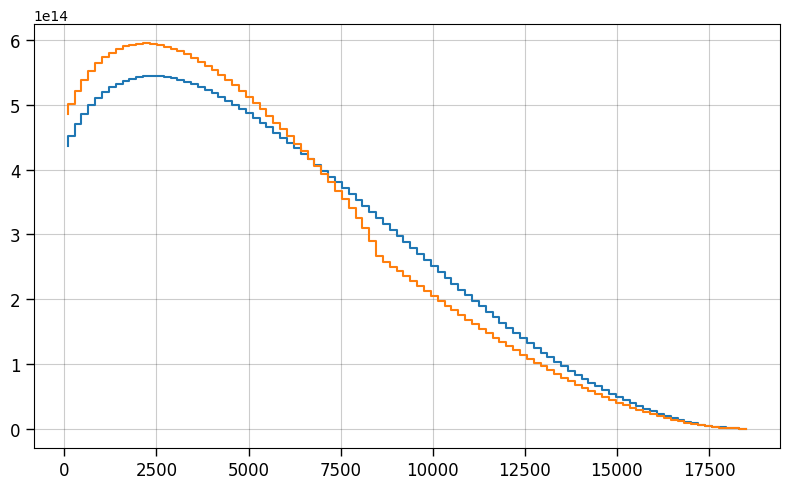

In [4]:
# evaluate model once
yData = model(eBinEdges, nEvents)

# plot as step histogram
plt.step(eBinCenters,yData)
plt.step(eBinCenters,model(eBinEdges, nEvents, 10000, 0.3))

pi.plotty()

### Covariance matrix

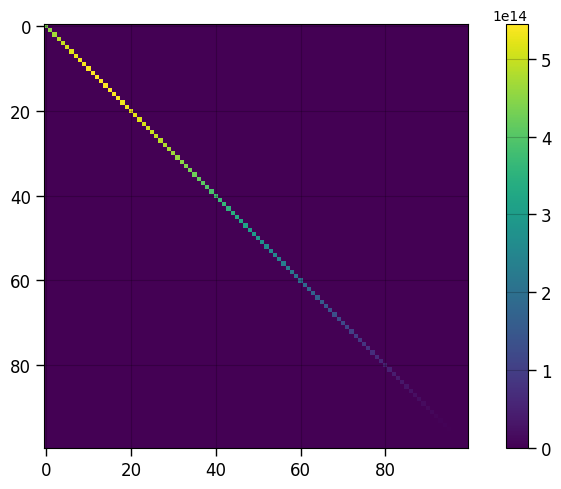

In [5]:
# calculate covariance matrix for statistical error
covStat = np.ones((nBins,nBins)) # initialize with ones to ensure inversibility
for i in range(nBins):
    covStat[i][i] = yData[i]

# for convenience also 1d error array for satstistics
yErr = np.sqrt(yData)

# show matrix
plt.imshow(covStat)
plt.colorbar()
pi.plotty()

### Chisquare grid calculation 

In [6]:
# define grid over mixing angles and sterile masses
mixings = np.logspace(-5,-8,10)
masses  = np.linspace(eBinEdges[0],eBinEdges[-1],20)

# invert covariance matrix
covInvStat = np.linalg.inv(covStat)

# calculate chisquare over grid
chisquareStat = np.zeros((len(mixings),len(masses)))

# set up nested progress bar
mb = master_bar(range(len(masses)),total_time=True)
mb.main_bar.comment = 'ms'
pb = progress_bar(range(len(mixings)), parent=mb)
mb.child.comment = 's2t'

for i in mb:
    for j in pb:
        ms  = masses[i]
        s2t = mixings[j]
        
        # evealuate model for fixed parameters
        yModel = model(eBinEdges, nEvents, mSterile=ms, sin2theta=s2t)
        
        # define local fit model function where normalisation can be varied
        def fitmodel(x,norm):    
            return norm*yModel
        
        # fit the normalisation
        par, cov = curve_fit(fitmodel,eBinCenters,yData,sigma=yErr,p0=[1.0])
        
        # evaluate fitmodel for fitted normalisation
        yFit = fitmodel(eBinCenters,*par)
        
        # calculate chisquare
        yResidual = yData - yFit        
        chisquareStat[j][i] = yResidual@covInvStat@yResidual

### Critical chisquare

In [7]:
# critical chisquare value for 90% confidence for 2 parameters (here: mass, mixing)
chiSquareCrit = stats.chi2.ppf(0.9, df=2)
print(f'Critical value for 90% confidence: {chiSquareCrit}')

Critical value for 90% confidence: 4.605170185988092


### Exclusion / Sensitivity plot

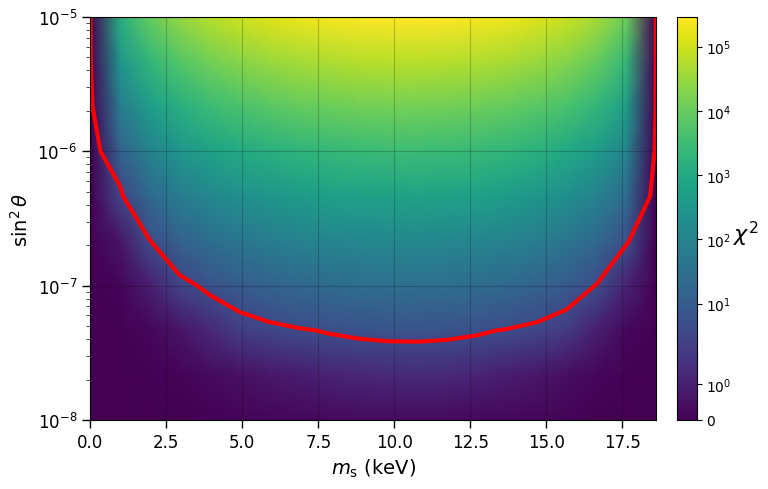

In [8]:
fig,ax=plt.subplots(1,1)

# plot as chisquare as color mesh and a colorbar
im = plt.pcolormesh(masses/1000, mixings, chisquareStat, norm=colors.SymLogNorm(2,base=10), shading='gouraud')
cbar = plt.colorbar(im, pad=0.03)
cbar.set_label(r'$\chi^2$',fontsize=16, rotation=0, labelpad=10)

# plot 90% exclusion contour
ax.contour(masses/1000, mixings, chisquareStat, 
            levels=[chiSquareCrit], colors='r', linewidths=3)

# show plot with labels
pi.plotty(axes=[ax], xlabel=r'$m_\mathrm{s}$ (keV)', ylabel=r'$\sin^2\theta$',log='y')